# MCNPy Tutorial: Sensitivity Analysis

This tutorial demonstrates how to use MCNPy for sensitivity analysis with MCNP perturbation runs. We'll cover:

- Computing sensitivity coefficients from MCNP input and output files
- Exploring the structure of sensitivity data objects
- Visualizing sensitivity profiles
- Analyzing nonlinearity with Taylor series expansion ratios
- Converting sensitivity data to pandas DataFrames
- Comparing multiple sensitivity datasets
- Creating SDF data for other applications
- Exporting sensitivity data to SDF format files

Let's start by importing the necessary modules and setting up our example files.

In [1]:
import mcnpy
from pathlib import Path

# Setup paths
repo_root = Path.cwd().resolve().parent
data_dir = repo_root / 'examples' / 'data'

# Load example input and MCTAL files
inputfile = data_dir / 'inputfile_example_1.i'
mctalfile = data_dir / 'mctalfile_example_1.m'

## 1. Computing Sensitivity Coefficients

The first step in sensitivity analysis is to compute sensitivity coefficients from MCNP input and output files. The `compute_sensitivity` function reads perturbation data from MCNP input files and results from MCTAL files, then computes sensitivity coefficients.

In [2]:
# Compute sensitivity coefficients
# Parameters:
# - inputfile: Path to MCNP input file with PERT cards
# - mctalfile: Path to MCNP MCTAL output file
# - tally: Tally number to analyze
# - zaid: ZAID of the nuclide being perturbed (e.g. 26056 for Fe-56)
# - label: Label for the sensitivity data set

# For Fe-56 (ZAID=26056)
sens_fe56 = mcnpy.compute_sensitivity(
    inputfile=inputfile,
    mctalfile=mctalfile, 
    tally=4,  
    zaid=26056,  # Fe-56
    label="Fe-56 Sensitivity"
)

# Display the sensitivity data object
sens_fe56

                 Sensitivity Data for Fe-56                 

Label:                           Fe-56 Sensitivity
Tally ID:                        4
Tally Name:                      shell Detector
Nuclide (ZAID):                  Fe-56 (26056)
Number of detector energy bins:  3
Number of perturbation bins:     44
Energy structure:                scale44
Reactions available:             1, 2, 4, 51, 52, 102, 103, 107
Taylor coefficients available:   Yes

Energy group ranges:
  - 0.00e+00_1.00e-01
  - 1.00e-01_1.00e+00
  - 1.00e+00_3.00e+00
  - integral


Available methods:
- .plot_sensitivity(energy=None, reaction=None, xlim=None) - Plot sensitivity profiles
- .plot_ratios(energy=None, reaction=None, p_range=None) - Plot Taylor ratio nonlinearity factors
- .to_dataframe() - Get full data as pandas DataFrame

Examples of accessing data:
- .data['0.00e+00_1.00e-01'][1] - Get coefficients for energy bin 0-0.1 MeV, reaction 1
- .data['integral'][2] - Get integral coefficients for reaction 2


## 2. Understanding SensitivityData Structure

A `SensitivityData` object contains sensitivity coefficients organized by detector energy range and reaction number. Let's explore its structure and attributes.

In [3]:
# Basic attributes
print(f"Nuclide: {sens_fe56.nuclide}")
print(f"Tally ID: {sens_fe56.tally_id}")
print(f"Available energy ranges: {sens_fe56.energies}")
print(f"Available reaction numbers: {sens_fe56.reactions}")
print(f"Number of perturbation energy bins: {len(sens_fe56.pert_energies) - 1}")

Nuclide: Fe-56
Tally ID: 4
Available energy ranges: ['0.00e+00_1.00e-01', '1.00e-01_1.00e+00', '1.00e+00_3.00e+00', 'integral']
Available reaction numbers: [1, 2, 4, 51, 52, 102, 103, 107]
Number of perturbation energy bins: 44


### Accessing Sensitivity Data

The sensitivity data is organized in a nested dictionary structure:
- First level: energy range (e.g., "0.00e+00_1.00e-01" or "integral")
- Second level: reaction number (MT number, e.g., 1 for total, 2 for elastic scattering)

Let's access some of this data:

In [4]:
# Get the first energy range
first_energy = sens_fe56.energies[0]

# Get the first reaction number
first_reaction = sens_fe56.reactions[0]

# Access the sensitivity coefficients data for this energy and reaction
sens_coeffs = sens_fe56.data[first_energy][first_reaction]

# Display the sensitivity coefficient data
sens_coeffs

             Sensitivity Coefficients             

Energy: 0.00e+00_1.00e-01
Reaction Number (MT): 1
Number of perturbation bins: 44
Unperturbed result (R₀): 2.643730e-09 ± 1.1700% (relative)

Data preview (values and relative errors):

     Energy Bin     |      Value      |   Rel. Error
----------------------------------------------
1.000e-11-3.000e-09 |    0.000000e+00 |     0.011700
3.000e-09-7.500e-09 |    0.000000e+00 |     0.011700
7.500e-09-1.000e-08 |    0.000000e+00 |     0.011700
...                                           
4.800e+00-6.434e+00 |    0.000000e+00 |     0.011700
6.434e+00-8.187e+00 |    0.000000e+00 |     0.011700
8.187e+00-2.000e+01 |    0.000000e+00 |     0.011700


Available methods:
- .lethargy - Get lethargy intervals as property
- .values_per_lethargy - Get sensitivity per lethargy as property
- .plot(ax=None, xlim=None) - Plot sensitivity coefficients
- .to_dataframe() - Export data as pandas DataFrame with columns:
    energy, reaction, e_lower, e_up

### Coefficients Object

The `Coefficients` object contains sensitivity values for a specific energy range and reaction. Let's examine its contents:

In [5]:
# Access key properties of the coefficient object
print(f"Energy range: {sens_coeffs.energy}")
print(f"Reaction number: {sens_coeffs.reaction}")
print(f"Unperturbed result (R₀): {sens_coeffs.r0:.6e} ± {sens_coeffs.e0*100:.4f}% (relative)")
print(f"\nPerturbation energy boundaries:")
print(sens_coeffs.pert_energies)

Energy range: 0.00e+00_1.00e-01
Reaction number: 1
Unperturbed result (R₀): 2.643730e-09 ± 1.1700% (relative)

Perturbation energy boundaries:
[1e-11, 3e-09, 7.5e-09, 1e-08, 2.53e-08, 3e-08, 4e-08, 5e-08, 7e-08, 1e-07, 1.5e-07, 2e-07, 2.25e-07, 2.5e-07, 2.75e-07, 3.25e-07, 3.5e-07, 3.75e-07, 4e-07, 6.25e-07, 1e-06, 1.77e-06, 3e-06, 4.75e-06, 6e-06, 8.1e-06, 1e-05, 3e-05, 0.0001, 0.00055, 0.003, 0.017, 0.025, 0.1, 0.4, 0.9, 1.4, 1.85, 2.354, 2.479, 3.0, 4.8, 6.434, 8.1873, 20.0]


## 3. Visualizing Sensitivity Profiles

MCNPy provides built-in methods for visualizing sensitivity profiles. Let's plot some sensitivity data:

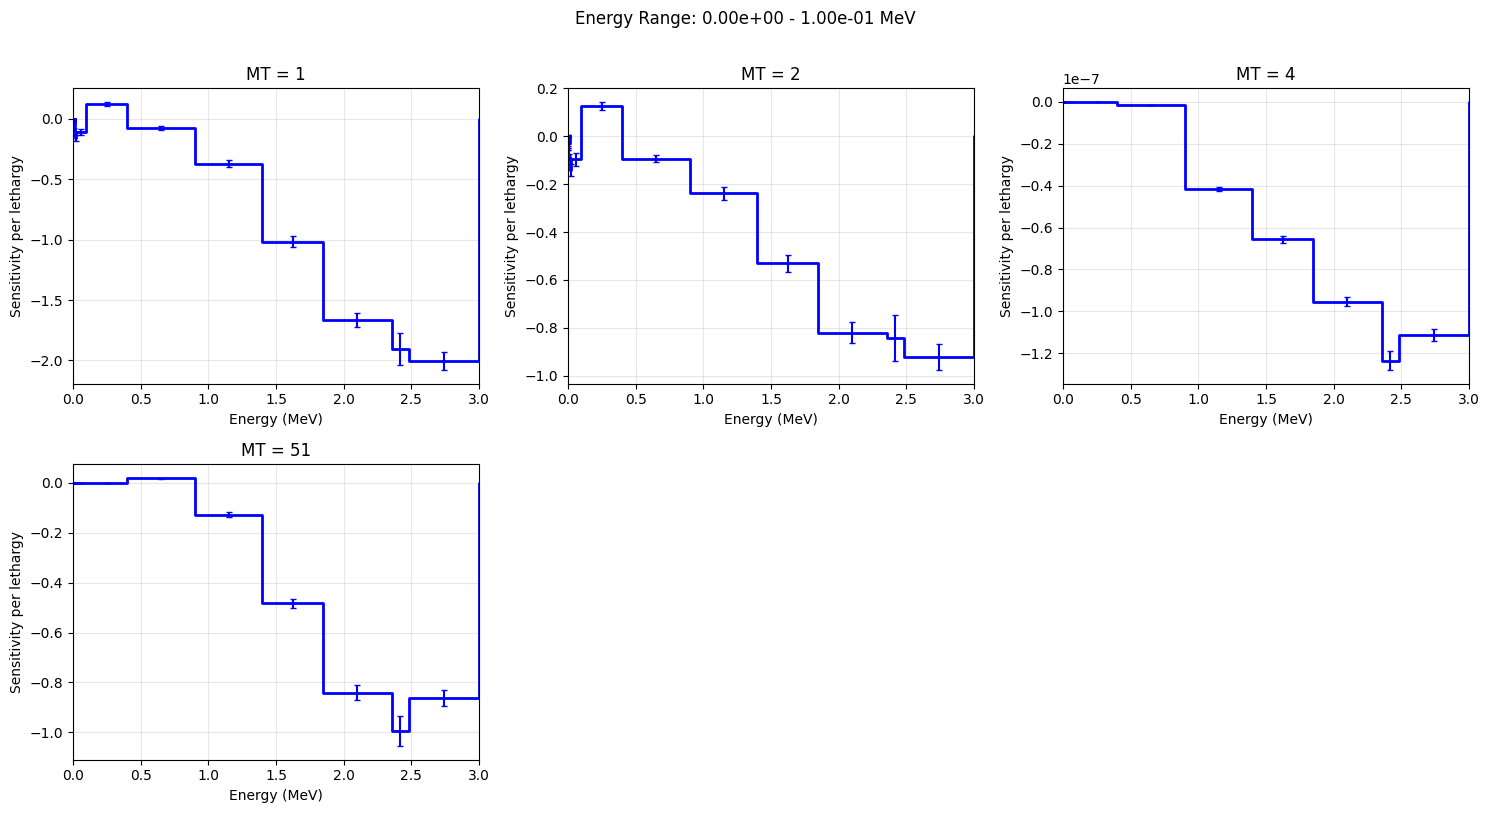

In [6]:
# Plot sensitivity profiles for specific energy range and reactions
# Parameters:
# - energy: Energy range to plot (string or list of strings)
# - reaction: Reaction number(s) to plot (integer or list of integers)
# - xlim: Optional x-axis limits as (min, max)

# Plot for the first energy range and first few reactions
sens_fe56.plot_sensitivity(
    energy=first_energy,
    reaction=sens_fe56.reactions[:4],  # Plot first 4 reactions
    xlim=(0, 3)  # Limit x-axis to 0-3 MeV
)

## 4. Taylor Coefficients and Nonlinearity Analysis

If second-order perturbation calculations were performed, MCNPy can analyze the nonlinearity of sensitivity coefficients using Taylor series expansion coefficients.

In [7]:
# Check if Taylor coefficients are available
if sens_fe56.coefficients:
    # Get the first energy range
    first_energy = next(iter(sens_fe56.coefficients.keys()))
    
    # Get the first reaction with Taylor coefficient data
    first_reaction = next(iter(sens_fe56.coefficients[first_energy].keys()))
    
    # Access the Taylor coefficient data
    taylor_coeffs = sens_fe56.coefficients[first_energy][first_reaction]
    
    # Display the Taylor coefficient object
    print(taylor_coeffs)
else:
    print("No Taylor coefficient data available. Second-order perturbations were not calculated.")

               Taylor Coefficient Data - MT 1               

Energy Range:                0.00e+00_1.00e-01
Reaction Number (MT):        1
Number of perturbation bins: 44
Energy structure:            scale44
Average c2/c1 ratio:         -8.717706e-01
Max |c2/c1| ratio:           1.785742e+01
 - at energy bin:            3.75e-07-4.00e-07 MeV

Data preview:

       Energy Bin      |       c1        |       c2        |    c2/c1    
----------------------------------------------------------------------
1.000e-11-3.000e-09 |    0.000000e+00 |    0.000000e+00 |          nan
3.000e-09-7.500e-09 |    0.000000e+00 |    0.000000e+00 |          nan
7.500e-09-1.000e-08 |    0.000000e+00 |    0.000000e+00 |          nan
...                                                                   
4.800e+00-6.434e+00 |    0.000000e+00 |    0.000000e+00 |          nan
6.434e+00-8.187e+00 |    0.000000e+00 |    0.000000e+00 |          nan
8.187e+00-2.000e+01 |    0.000000e+00 |    0.000000e+00 |          n

### Visualizing Nonlinearity

If Taylor coefficient data is available, we can visualize the nonlinearity factors (ratios of c2 to c1):

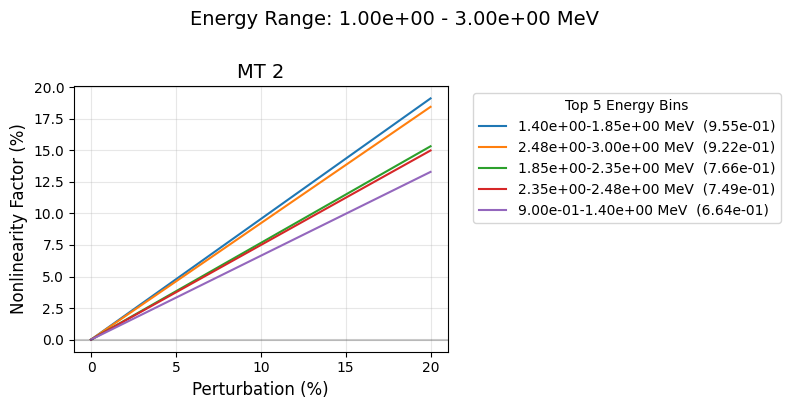

In [8]:
# Plot nonlinearity using Taylor coefficients for specific energy range and reactions
sens_fe56.plot_ratio(
    energy=sens_fe56.energies[2],
    reaction=[2],  # Plot only reaction MT=2
    top_n=5  # Show top 5 energy bins with highest nonlinearity
)

### Perturbed Response Analysis

For a more detailed analysis, we can plot the perturbed response as a function of perturbation magnitude using Taylor coefficients:

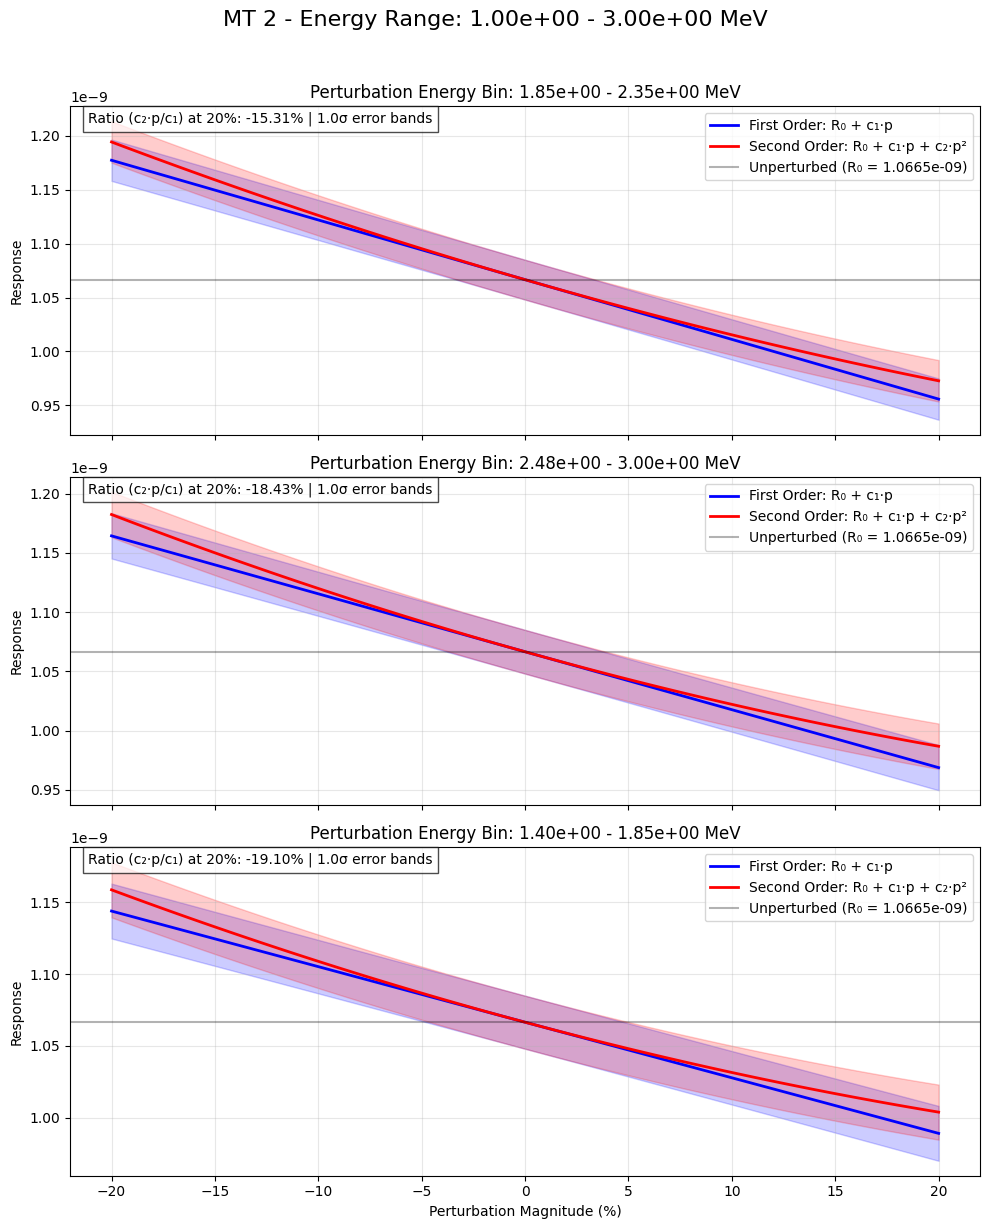

In [9]:
# Plot perturbed response for specific energy range and reaction
sens_fe56.plot_perturbed_response(
    energy=sens_fe56.energies[2],
    reaction=[2],  # Plot only reaction MT=2
    p_range=(-20, 20),  # Perturbation range in percent
    top_n=3,  # Show top 3 energy bins with highest nonlinearity
    plot_type='comparative'  # Compare first-order and second-order approximations
)

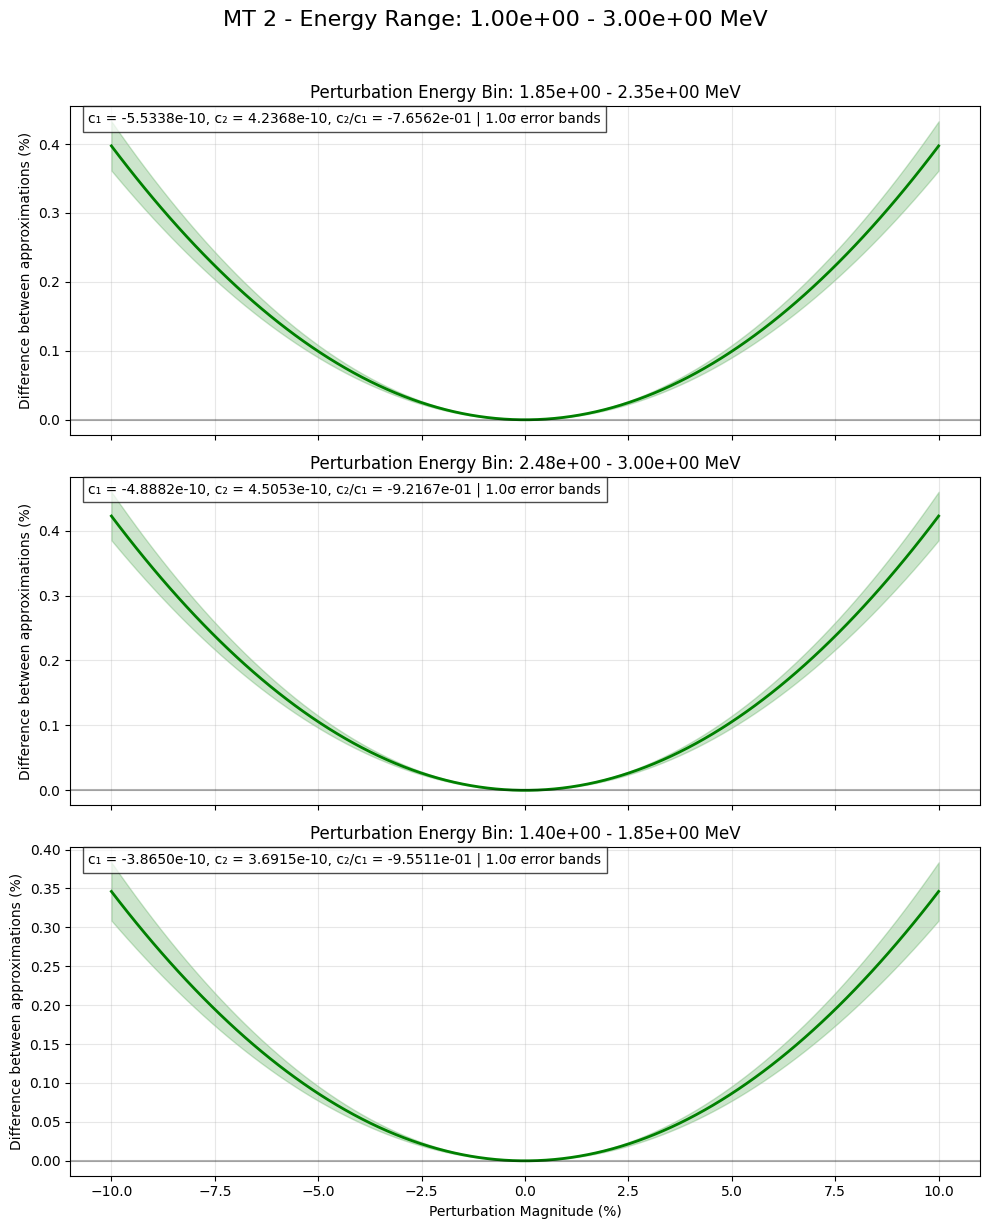

In [10]:
sens_fe56.plot_perturbed_response(
    energy=sens_fe56.energies[2],
    reaction=[2],  # Plot only reaction MT=2
    p_range=(-10, 10),
    top_n=3,
    plot_type='difference'  # Show the difference between approximations
)

## 5. Converting Sensitivity Data to DataFrames

For more advanced data analysis, you can convert sensitivity data to pandas DataFrames:

In [11]:
# Convert sensitivity data to a pandas DataFrame
sens_df = sens_fe56.to_dataframe()

# Display the DataFrame
sens_df.head()

,det_energy,energy_lower,energy_upper,reaction,e_lower,e_upper,sensitivity,error,label,tally_name
0,0.00e+00_1.00e-01,0.0,0.1,1,1.000000e-11,3.000000e-09,0.000000,0.000000,Fe-56 Sensitivity,shell Detector
1,0.00e+00_1.00e-01,0.0,0.1,1,3.000000e-09,7.500000e-09,0.000000,0.000000,Fe-56 Sensitivity,shell Detector
2,0.00e+00_1.00e-01,0.0,0.1,1,7.500000e-09,1.000000e-08,0.000000,0.000000,Fe-56 Sensitivity,shell Detector
3,0.00e+00_1.00e-01,0.0,0.1,1,1.000000e-08,2.530000e-08,-0.000118,-0.000118,Fe-56 Sensitivity,shell Detector
4,0.00e+00_1.00e-01,0.0,0.1,1,2.530000e-08,3.000000e-08,-0.000762,-0.000762,Fe-56 Sensitivity,shell Detector


## 6. Comparing Multiple Sensitivity Datasets

MCNPy provides a utility function `plot_sens_comparison` for comparing multiple sensitivity datasets. Let's compute another sensitivity dataset and compare them.

In [12]:
# Load example input and MCTAL files
inputfile2 = data_dir / 'inputfile_example_2.i'
mctalfile2 = data_dir / 'mctalfile_example_2.m'

In [13]:
# Compute another sensitivity dataset (for example, H-1)
sens_h1 = mcnpy.compute_sensitivity(
    inputfile=inputfile2,
    mctalfile=mctalfile2, 
    tally=4,
    zaid=1001,  # H-1
    label="H-1 Sensitivity"
)

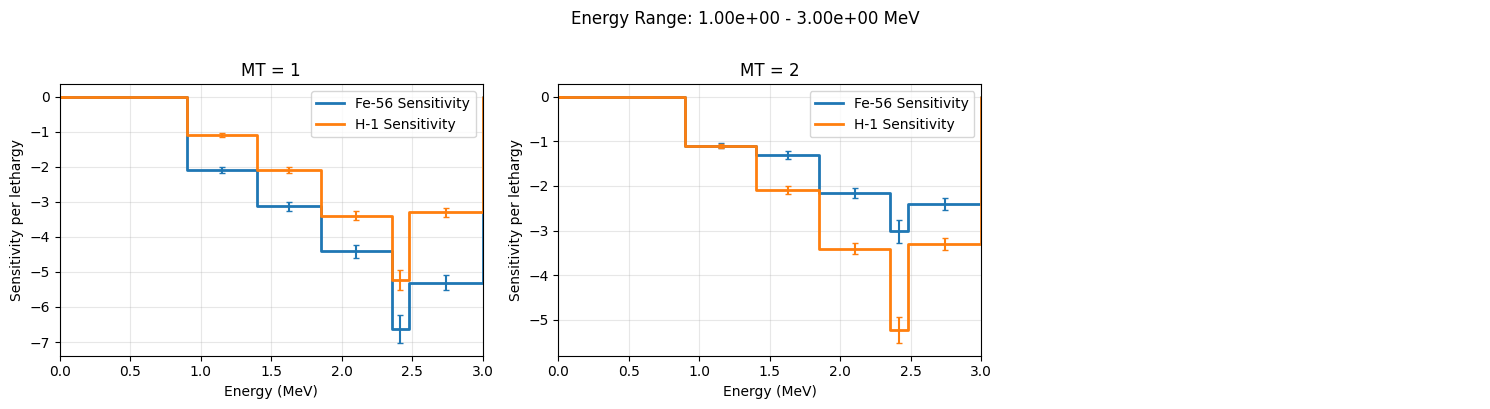

In [14]:
# Compare sensitivity data for Fe-56 and O-16
mcnpy.plot_sens_comparison(
    sens_list=[sens_fe56, sens_h1],
    energy=sens_fe56.energies[2],
    reactions=[1, 2],  # Compare total and elastic scattering reactions
    xlim=(0, 3)  # Limit x-axis to 0-3 MeV
)

## 7. Creating SDF Data

For compatibility with other nuclear data sensitivity tools, MCNPy can create Sensitivity Data Format (SDF) objects:

In [15]:
# Create SDF data from sensitivity datasets
sdf_data = mcnpy.create_sdf_data(
    sensitivity_data_list=[sens_fe56, sens_h1],
    energy=sens_fe56.energies[2],
    title="Example SDF Dataset"
)

# Display the SDF data
sdf_data

Skipping H-1 inelastic (MT=4): All sensitivity coefficients are zero
Skipping H-1 inelastic-1st (MT=51): All sensitivity coefficients are zero
Skipping H-1 inelastic-2nd (MT=52): All sensitivity coefficients are zero
Skipping H-1 n,p (MT=103): All sensitivity coefficients are zero
Skipping H-1 n,alpha (MT=107): All sensitivity coefficients are zero


                    SDF Data: Example SDF Dataset                     
                   Energy range: 1.00e+00_3.00e+00                    

Response value:           1.066520e-09 ± 1.730000e-02
Energy groups:            44
Energy structure:         scale44
Sensitivity profiles:     11
Unique nuclides:          2

Energy grid (preview):
    1.000000e-11, 3.000000e-09, 7.500000e-09, ... , 6.434000e+00, 8.187300e+00, 2.000000e+01

Nuclides and reactions (with access indices):

  Fe-56:
    total (MT=1)                   access with .data[0]
    elastic (MT=2)                 access with .data[1]
    inelastic (MT=4)               access with .data[2]
    inelastic-1st (MT=51)          access with .data[3]
    inelastic-2nd (MT=52)          access with .data[4]
    n,gamma (MT=102)               access with .data[5]
    n,p (MT=103)                   access with .data[6]
    n,alpha (MT=107)               access with .data[7]

  H-1:
    total (MT=1)                   access with .data[

### Advanced: Filtering Reactions for SDF Data

You can also create SDF data with specific reactions for each sensitivity dataset:

In [16]:
# Create SDF data with specific reactions for each dataset
sdf_filtered = mcnpy.create_sdf_data(
    sensitivity_data_list=[
        (sens_fe56, [1, 2]),  # Only include reactions 1 and 2 for Fe-56
        (sens_h1, [1])        # Only include reaction 1 for H-1
    ],
    energy=sens_fe56.energies[2],
    title="Filtered SDF Dataset"
)

# Display the filtered SDF data
sdf_filtered

                    SDF Data: Filtered SDF Dataset                    
                   Energy range: 1.00e+00_3.00e+00                    

Response value:           1.066520e-09 ± 1.730000e-02
Energy groups:            44
Energy structure:         scale44
Sensitivity profiles:     3
Unique nuclides:          2

Energy grid (preview):
    1.000000e-11, 3.000000e-09, 7.500000e-09, ... , 6.434000e+00, 8.187300e+00, 2.000000e+01

Nuclides and reactions (with access indices):

  Fe-56:
    total (MT=1)                   access with .data[0]
    elastic (MT=2)                 access with .data[1]

  H-1:
    total (MT=1)                   access with .data[2]


Available methods:
- .write_file() - Write SDF data to a file
- .group_inelastic_reactions() - Group MT 51-91 into MT 4

### Accessing SDF Data

The sdf data is organized in a list named data. Inside you will find the data for each isotope-reaction.

Let's access some of this data:

In [17]:
# Accessing individual reaction data within the SDF object
reaction_data = sdf_data.data[0]  # First reaction in the dataset

# Display reaction data
print(reaction_data)

# Access different properties of the reaction data
print(f"Accessing first reaction: {reaction_data.nuclide} {reaction_data.reaction_name} (MT={reaction_data.mt})")
print(f"Total sensitivity: {sum(reaction_data.sensitivity):.6e}")
print(f"Number of energy groups: {len(reaction_data.sensitivity)}")

                     SDF Reaction Data                      

Nuclide:                  Fe-56 (ZAID 26056)
Reaction:                 total (MT 1)
Energy groups:            44
Total sensitivity:        -4.214661e+00

Sensitivity coefficients (preview):
  Group      Sensitivity       Rel. Error
  -----    --------------    ------------
  1          0.000000e+00    1.730000e-02
  2          0.000000e+00    1.730000e-02
  3          0.000000e+00    1.730000e-02
  ...
  42         0.000000e+00    1.730000e-02
  43         0.000000e+00    1.730000e-02
  44         0.000000e+00    1.730000e-02

Accessing first reaction: Fe-56 total (MT=1)
Total sensitivity: -4.214661e+00
Number of energy groups: 44


## 8. Export SDF data to SDF File

The SDF (Sensitivity Data Format) data object provides methods to export sensitivity profiles to standardized files and perform data manipulations such as reaction grouping. This section demonstrates how to:

1. Export SDF data to files in the standard format
2. Group related inelastic scattering reactions

For the export process, the `.write_file()` method creates output files in a specified directory with names based on the contained isotopes and reactions. When grouping inelastic reactions, all discrete inelastic scattering reactions (MT 51-91) are combined into the general inelastic scattering reaction (MT 4).

In [18]:
# Export SDF data to a file (creating an output directory)
sdf_data.write_file()

SDF file saved successfully: /home/MONLEON-JUAN/MCNPy/examples/Example_SDF_Dataset_1.00e+00_3.00e+00.sdf


In [19]:
# Grouping inelastic reactions (MT 51-91) into MT 4 and writing the sdf file.
sdf_data.group_inelastic_reactions(replace=True)

sdf_data.write_file()

Updated MT 4 for Fe-56 (ZAID 26056)
Removed MT 51, 52 for Fe-56 (ZAID 26056)
SDF file saved successfully: /home/MONLEON-JUAN/MCNPy/examples/Example_SDF_Dataset_1.00e+00_3.00e+00.sdf


## 9. Summary

In this tutorial, we've explored the sensitivity analysis capabilities of MCNPy:

1. **Computing Sensitivity Coefficients**: Using `compute_sensitivity` to extract sensitivity data from MCNP files
2. **Exploring Sensitivity Data**: Understanding the structure of `SensitivityData`, `Coefficients`, and `TaylorRatio` objects
3. **Visualizing Sensitivity Profiles**: Using built-in plotting methods to visualize sensitivity coefficients
4. **Taylor Series Analysis**: Analyzing nonlinearity with Taylor coefficients and perturbed response plots
5. **DataFrames**: Converting sensitivity data to pandas DataFrames for further analysis
6. **Comparisons**: Comparing sensitivity profiles across multiple nuclides
7. **SDF Data**: Creating SDF data object
8. **Export SDF Data**: Export sensitivity data to SDF format for compatibility with other tools

These tools enable detailed sensitivity analysis for nuclear applications, helping users understand how different parameters affect simulation results.